<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 

In [8]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


In [9]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

SNR : 18


In [0]:
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [12]:
Xsnr = np.zeros(shape=(X.shape[0],X.shape[1],X.shape[2]+1))
for i in range(X.shape[0]):
    snr = int(labels[i,1])
    Xsnr[i,0,:] = np.insert(X[i,0,:],0,snr)
    Xsnr[i,1,:] = np.insert(X[i,1,:],0,snr)
    
print(Xsnr.shape)

(160000, 2, 129)


In [13]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 1, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(128000, 2, 129)
(32000, 2, 129)


In [14]:
X_train = X_train[:,:,1:] # snr important for train

y_test18 = []
X_test18 = []

for i in range(X_test.shape[0]):
    if X_test[i,0,0] == 18:
        X_test18.append(X_test[i])
        y_test18.append(y_test[i])
        
X_test18 = np.array(X_test18)
y_test18 = np.array(y_test18)        
X_test18 = X_test18[:,:,1:]


print(X_train.shape)
print(X_test18.shape)

(128000, 2, 128)
(1653, 2, 128)


In [15]:
# Change IQ to amplitude and phase
X_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_train_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##
X_cmplx = X_test18[:,0,:] + 1j* X_test18[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_test18[:,1,:],X_test18[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_test18_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##

print(X_train_AmpPhs.shape)
print(X_test18_AmpPhs.shape)

(128000, 2, 128)
(1653, 2, 128)


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = X_train.reshape([X_train.shape[0],256])
#X_train = X_train_AmpPhs.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])
#X_test18 = X_test18_AmpPhs.reshape([X_test18.shape[0],256])
X_test18 = sc.transform(X_test18)
X_test18 = X_test18.reshape([X_test18.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test18 = X_test18.reshape(-1,2, 128, 1)

print(X_train.shape)
print(X_test18.shape)

(128000, 2, 128, 1)
(1653, 2, 128, 1)


# Making CNN0 model 
(Article : Convolutional Radio Modulation Recognition Networks - Timothy J. O’Shea)


In [17]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.6
classifier.add(Conv2D(filters=64, kernel_size=(1,3), input_shape =  (2,128,1), padding='same', activation = 'relu')) 
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(filters=16,kernel_size=(2,3),  padding='same', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

W0828 10:44:14.780005 139861057308544 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0828 10:44:14.814134 139861057308544 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 128, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 128, 16)        6160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 128, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=8)`


#Making CNN1 model (one-convolutional-layer)
(Thesis :DEEP NEURAL NETWORK ARCHITECTURES FOR MODULATION CLASSIFICATION)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.6

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

# Making CNN2 model  (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,(1,3), input_shape =  (2,128,1), activation = 'relu', padding='same')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(2,3), activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")


#Making CNN3 model (two-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4

classifier.add(Conv2D(80,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

#Making CNN4 model (four-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,1,3, input_shape =  (2,128,1), activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu')) # 256=number of filter
classifier.add(Dropout(rate = dout))

classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")


#Making CNN5 model (five-convolutional-layer)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(384,1,3, input_shape =  (2,128,1), activation = 'relu')) 
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,1,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Flatten())

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dropout(rate = dout))
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()
print("Model Created!")

# Fitting model

In [18]:
batch = 1024
epoch = 100

history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test18, y_test18))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Train on 128000 samples, validate on 1653 samples
Epoch 1/100
128000/128000 [==============================] - 10s 81us/step - loss: 1.9964 - acc: 0.1774 - val_loss: 1.7084 - val_acc: 0.2420
Epoch 2/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.8138 - acc: 0.2476 - val_loss: 1.3623 - val_acc: 0.4713
Epoch 3/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.6894 - acc: 0.3005 - val_loss: 1.1439 - val_acc: 0.5620
Epoch 4/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.5758 - acc: 0.3534 - val_loss: 0.7991 - val_acc: 0.6909
Epoch 5/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.4426 - acc: 0.4039 - val_loss: 0.6434 - val_acc: 0.7175
Epoch 6/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.3894 - acc: 0.4241 - val_loss: 0.5937 - val_acc: 0.7356
Epoch 7/100
128000/128000 [==============================] - 7s 56us/step - loss: 1.3524 - acc: 0.4364 - val_

# Save model

In [19]:
dic = "/content/drive/My Drive/Colab Notebooks/"
classifier.save(dic+f'SaveModel/CNN0-ba{batch}-ep{epoch}-(dout=0.6)-input(IQ)(SNR=all).h5')

f = open(dic+f'SaveModel/CNN0-ba{batch}-ep{epoch}-(dout=0.6)-input(IQ)(SNR=all)-history.txt',"w")
f.write( str(classifier.history.history) )
f.close()

print('Model Saved!')

Model Saved!



# Prediction(only SNR=18)

In [21]:
y_pred = classifier.predict(X_test18)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test18, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


128000/128000 [==============================] - 10s 79us/step
Acc Test :  0.8354506957408376
Acc Train :  0.5644609375


# Plot Confusion Matrix

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)    

128000/128000 [==============================] - 10s 81us/step
Acc Test :  0.8354506957408376
Acc Train :  0.5644609375


SNR:  -20
1636/1636 [==============================] - 0s 82us/step
0.132640586797066
Plot Saved!
SNR:  -18
1630/1630 [==============================] - 0s 90us/step
0.1171779141424258
Plot Saved!
SNR:  -16
1606/1606 [==============================] - 0s 101us/step
0.11394769615803382
Plot Saved!
SNR:  -14
1633/1633 [==============================] - 0s 101us/step
0.1316595223515003
Plot Saved!
SNR:  -12
1567/1567 [==============================] - 0s 101us/step
0.13018506693094492
Plot Saved!
SNR:  -10
1561/1561 [==============================] - 0s 92us/step
0.16848174242981728
Plot Saved!
SNR:  -8
1605/1605 [==============================] - 0s 93us/step
0.32585669781931464
Plot Saved!
SNR:  -6
1605/1605 [==============================] - 0s 103us/step
0.41370716518330797
Plot Saved!
SNR:  -4
1600/1600 [==============================] - 0s 96us/step
0.51875
Plot Saved!
SNR:  -2
1642/1642 [==============================] - 0s 91us/step
0.620584653007563
Plot Saved!
SNR:  0
1570/1570 

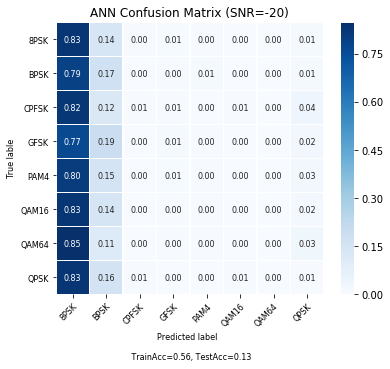

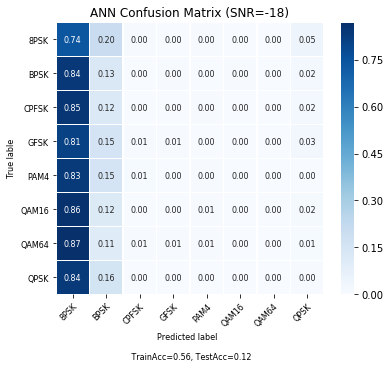

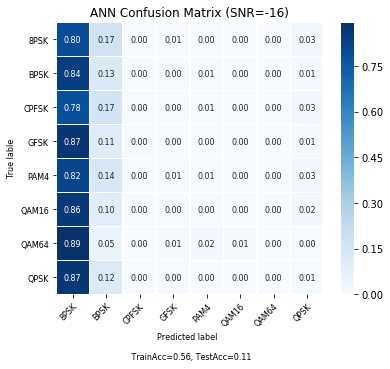

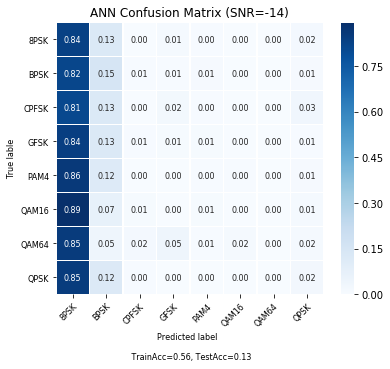

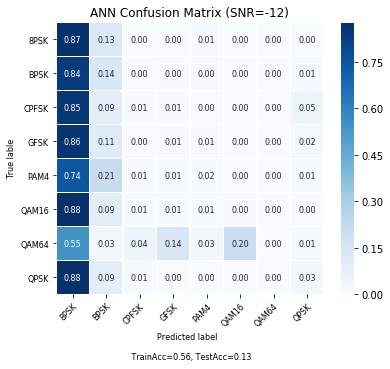

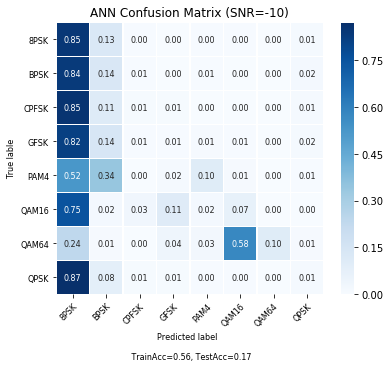

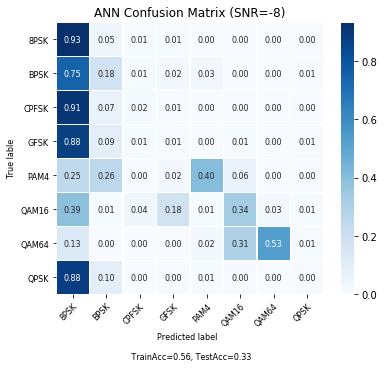

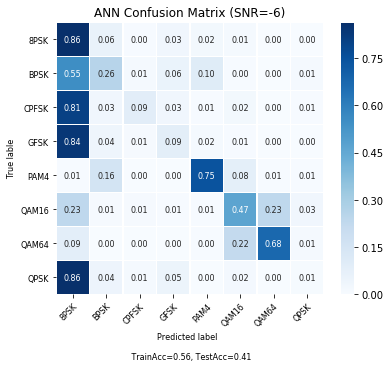

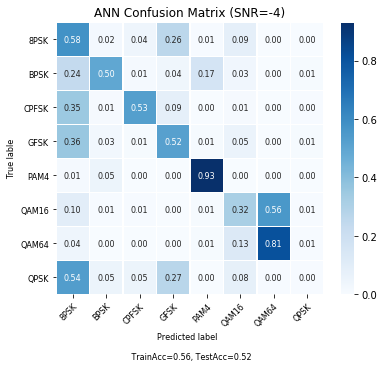

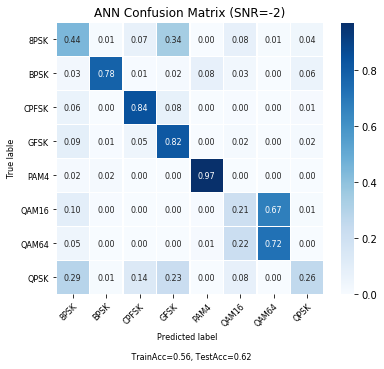

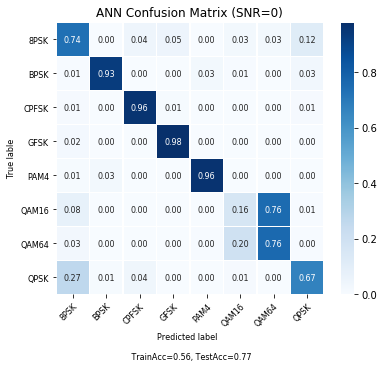

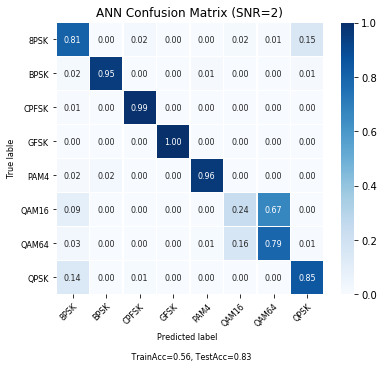

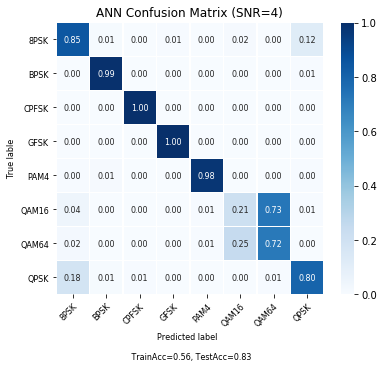

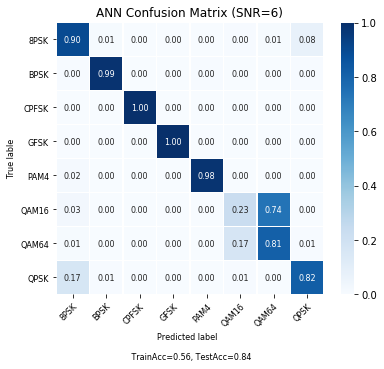

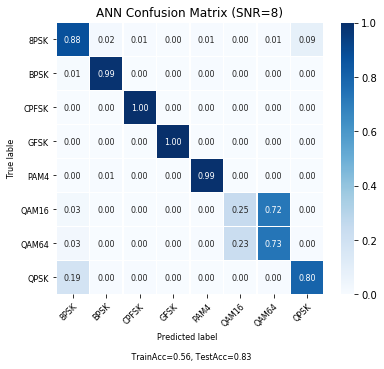

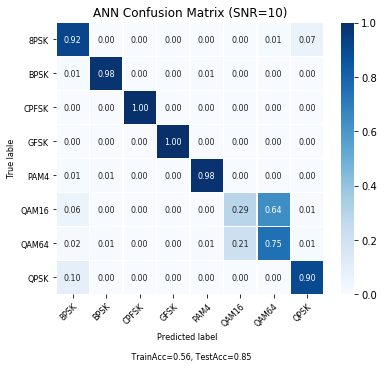

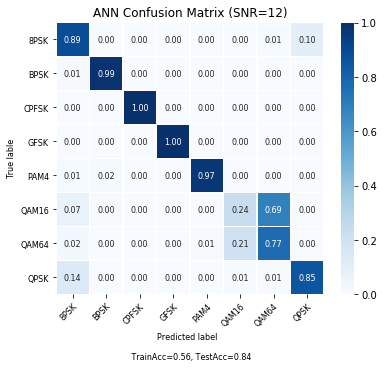

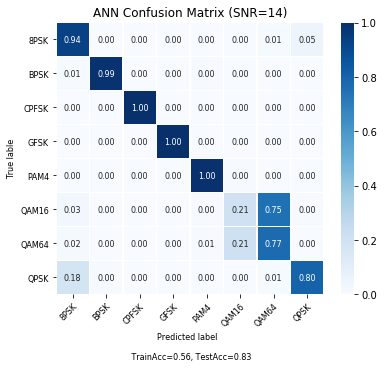

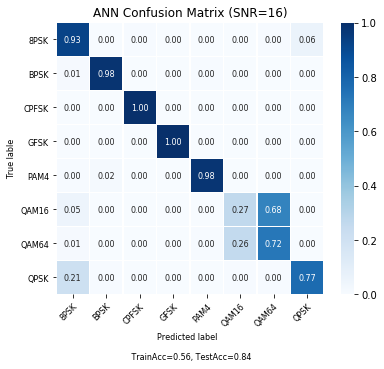

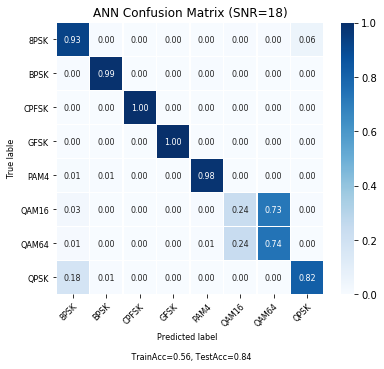

In [24]:
dic = "/content/drive/My Drive/Colab Notebooks/"
acc = []

for snr in snrList:
  print('SNR: ', snr)
    
  y_test_snr = []
  X_test_snr = []
  for i in range(X_test.shape[0]):
    if X_test[i,0,0] == int(snr):
      X_test_snr.append(X_test[i])
      y_test_snr.append(y_test[i])
        
  X_test_snr = np.array(X_test_snr)
  y_test_snr = np.array(y_test_snr)        
  X_test_snr = X_test_snr[:,:,1:]
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256])
  X_test_snr = sc.transform(X_test_snr)
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],2,128])
  
  X_test_snr = X_test_snr.reshape(-1,2, 128, 1) # For CNN
    
  acc_test = classifier.evaluate(X_test_snr, y_test_snr)[1]
  acc.append(acc_test)
  print(acc_test)
  
  y_pred = classifier.predict(X_test_snr)
  y_pred = np.argmax(y_pred, axis=1)

  y_real = np.argmax(y_test_snr, axis=1)
  # Making the Confusion Matrix
  cm = confusion_matrix(y_real, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
  cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
  plt.figure(figsize=(6, 5))
  ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Blues")

  plt.title(f"ANN Confusion Matrix (SNR={snr})")
  plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
  plt.ylabel("True lable", fontsize=8)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
  plt.setp(ax.get_yticklabels(), fontsize=8)
  fig = ax.get_figure()

  fig.savefig(dic+f"/Pic/CNN/CNN0-ba{batch}-ep{epoch}-(dout=0.6)-input(IQ)(SNR={snr}).png", dpi=175, bbox_inches='tight')
  fig.savefig(dic+f"/Pic/CNN/CNN0-ba{batch}-ep{epoch}-(dout=0.6)-input(IQ)(SNR={snr}).eps", bbox_inches='tight')
  print("Plot Saved!")
   

  del(y_test_snr)
  del(X_test_snr)
      
print(acc)    
    

In [0]:
X_test.shape

(1653, 2, 128, 1)

Vs SNR if **AmpPhas**

In [0]:
acc = []

for snr in snrList:
  print('SNR: ', snr)
    
  y_test_snr = []
  X_test_snr = []
  for i in range(X_test.shape[0]):
    if X_test[i,0,0] == int(snr):
      X_test_snr.append(X_test[i])
      y_test_snr.append(y_test[i])
        
  X_test_snr = np.array(X_test_snr)
  y_test_snr = np.array(y_test_snr)        
  X_test_snr = X_test_snr[:,:,1:]
  
  X_cmplx = X_test_snr[:,0,:] + 1j* X_test_snr[:,1,:]    
  X_amp = np.abs(X_cmplx)
  X_ang = np.arctan2(X_test_snr[:,1,:],X_test_snr[:,0,:]) / np.pi
        
  X_amp = np.reshape(X_amp,(-1,1,128))
  X_ang = np.reshape(X_ang,(-1,1,128))
        
  X_test_snr = np.concatenate((X_amp,X_ang), axis=1) 
  
  
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256])
  X_test_snr = sc.transform(X_test_snr)
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],2,128])
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256]) # Only for ANN
    
  acc_test = classifier.evaluate(X_test_snr, y_test_snr)[1]
  acc.append(acc_test)
  print(acc_test)
    
print(acc)    



Laod Model

In [0]:
from keras.models import load_model
dic = "/content/drive/My Drive/Colab Notebooks/"

model = load_model(dic+f'SaveModel/CNN0-ba{batch}-ep{epoch}-(dout=0.6)-input(IQ)(SNR=all).h5')

print('Model loaded!')

In [0]:
classifier = model
model.get_config()



